
# Fase 2: Comprensión de los Datos

**Contexto (Fase 1):** Queremos analizar el comportamiento de compra para identificar patrones por **categoría** y **segmentación por género**, cuantificar riesgos de datos y dejar insumos claros para la Fase 3 (limpieza + features: edad, antigüedad, RFM, preferencia de categoría).

**Objetivos de esta libreta**
- Recolectar y cargar **3 datasets** desde el **Catálogo de Kedro**: `customer_raw`, `product_raw`, `purchase_raw`.
- Describir los datos (dimensiones, tipos, resúmenes).
- Explorar (EDA): distribuciones, ventas por categoría, estacionalidad, top clientes.
- Verificar **calidad**: nulos, duplicados, integridad referencial, reglas de negocio, fechas y outliers.


In [20]:

# %% Imports y configuración
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (11, 5)


In [21]:

# %% Carga robusta vía Catálogo de Kedro
from kedro.framework.startup import bootstrap_project
from kedro.framework.session import KedroSession

# Detectar raíz del proyecto (donde está pyproject.toml)
def find_project_root(start: Path) -> Path:
    p = start.resolve()
    while p != p.parent:
        if (p / 'pyproject.toml').exists():
            return p
        p = p.parent
    raise FileNotFoundError('No se encontró pyproject.toml al subir directorios.')

PROJECT_ROOT = find_project_root(Path.cwd())
bootstrap_project(PROJECT_ROOT)

with KedroSession.create(project_path=PROJECT_ROOT) as session:
    context = session.load_context()
    catalog = context.catalog
    customer = catalog.load('customer_raw')
    product  = catalog.load('product_raw')
    purchase = catalog.load('purchase_raw')

print('Raíz del proyecto:', PROJECT_ROOT)
(customer.head(3), product.head(3), purchase.head(3))


[09/16/25 04:53:39] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=837705;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=896400;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[09/16/25 04:53:40] INFO     Loading data from customer_raw (CSVDataset)...                    ]8;id=317524;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=705812;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from product_raw (CSVDataset)...                     ]8;id=485346;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=313006;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from purchase_raw (CSVDataset)...                    ]8;id=144673;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=293519;file://C:\Users\amaro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Raíz del proyecto: E:\kedro\kedroev1



(
       customer_id first_name last_name  gender       date_of_birth  \
0            1     Robert     Smith  Female 1994-06-14 21:40:27   
1            2      Emily    Garcia  Female 1989-09-21 17:56:31   
2            3    Jessica     Brown    Male 1984-01-21 21:43:13   

                       email  phone_number         signup_date       address  \
0       jane.davis1@mail.com  634-106-4981 2016-10-16 17:23:25  8465 Main St   
1  robert.williams2@mail.com  386-635-5998 2021-04-04 14:24:06   305 Main St   
2      emily.davis3@mail.com  627-341-5213 2018-04-22 04:51:57   5725 Oak St   

          city state  zip_code  
0  San Antonio    CA     35566  
1     New York    AZ     23187  
2      Chicago    AZ     99188  ,
       product_id product_name category  price_per_unit   brand  \
0           1       Butter    Dairy           28.58  BrandB   
1           2       Butter    Meats           22.66  BrandB   
2           3         Milk    Meats           26.52  BrandE   

      product


## Descripción de los datos
Dimensiones, tipos y resúmenes básicos.


In [22]:

# %% Descripción (shapes, dtypes, resúmenes)
print('Dimensiones:')
print(' - customer :', customer.shape)
print(' - product  :', product.shape)
print(' - purchase :', purchase.shape)

print('\nTipos (dtypes):')
print('customer:\n', customer.dtypes)
print('\nproduct:\n', product.dtypes)
print('\npurchase:\n', purchase.dtypes)

# Resúmenes numéricos
num_summary_customer = customer.select_dtypes(include=[np.number]).describe().T
num_summary_product  = product.select_dtypes(include=[np.number]).describe().T
num_summary_purchase = purchase.select_dtypes(include=[np.number]).describe().T

# Resumen categórico (top N valores)
def describe_categoricals(df, top_n=5):
    cats = df.select_dtypes(include=['object', 'category']).columns.tolist()
    out = {}
    for c in cats:
        vc = df[c].value_counts(dropna=False).head(top_n)
        out[c] = {'num_unique': int(df[c].nunique(dropna=True)), 'top': vc.to_dict()}
    return out

cat_summary_customer = describe_categoricals(customer)
cat_summary_product  = describe_categoricals(product)

print('\nResumen numérico - purchase:\n', num_summary_purchase)
cat_summary_customer, cat_summary_product


Dimensiones:
 - customer : (1000, 12)
 - product  : (500, 6)
 - purchase : (10308, 6)

Tipos (dtypes):
customer:
 customer_id               int64
first_name               object
last_name                object
gender                   object
date_of_birth    datetime64[ns]
email                    object
phone_number             object
signup_date      datetime64[ns]
address                  object
city                     object
state                    object
zip_code                  int64
dtype: object

product:
 product_id               int64
product_name            object
category                object
price_per_unit         float64
brand                   object
product_description     object
dtype: object

purchase:
 purchase_id               int64
customer_id               int64
product_id                int64
purchase_date    datetime64[ns]
quantity                  int64
total_amount            float64
dtype: object

Resumen numérico - purchase:
                 count       


(
    {
        'first_name': {
            'num_unique': 10,
            'top': {'John': 118, 'Alex': 110, 'Linda': 107, 'Michael': 107, 'Jessica': 100}
        },
        'last_name': {
            'num_unique': 10,
            'top': {'Johnson': 113, 'Smith': 106, 'Rodriguez': 103, 'Martinez': 101, 'Jones': 101}
        },
        'gender': {'num_unique': 2, 'top': {'Female': 533, 'Male': 467}},
        'email': {
            'num_unique': 1000,
            'top': {
                'jane.davis1@mail.com': 1,
                'robert.williams2@mail.com': 1,
                'emily.davis3@mail.com': 1,
                'jessica.williams4@mail.com': 1,
                'robert.martinez5@mail.com': 1
            }
        },
        'phone_number': {
            'num_unique': 1000,
            'top': {
                '634-106-4981': 1,
                '386-635-5998': 1,
                '627-341-5213': 1,
                '126-662-8981': 1,
                '758-947-2802': 1
            }
  


## Exploración inicial (EDA)
- Distribuciones: `total_amount`, `quantity`, `price_per_unit`.
- Oferta vs demanda por **categoría**.
- Estacionalidad (ventas por mes).
- Top 10 clientes por gasto.


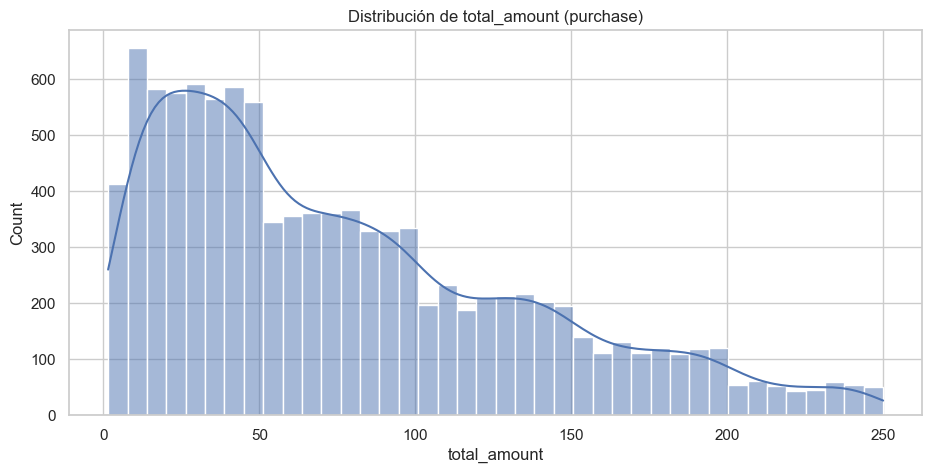

In [23]:

# %% Distribución de total_amount (purchase)
ax = sns.histplot(purchase['total_amount'].dropna(), bins=40, kde=True)
ax.set_title('Distribución de total_amount (purchase)')
ax.set_xlabel('total_amount')
plt.show()


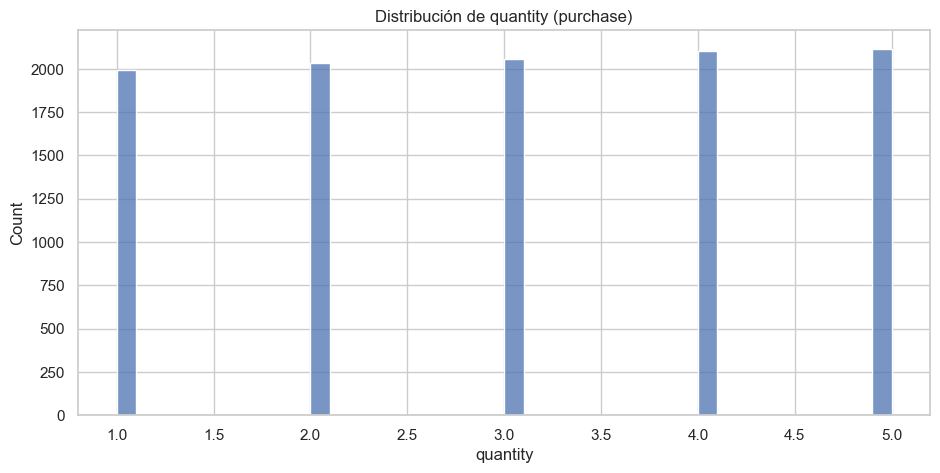

In [24]:

# %% Distribución de quantity (purchase)
ax = sns.histplot(purchase['quantity'].dropna(), bins=40, kde=False)
ax.set_title('Distribución de quantity (purchase)')
ax.set_xlabel('quantity')
plt.show()


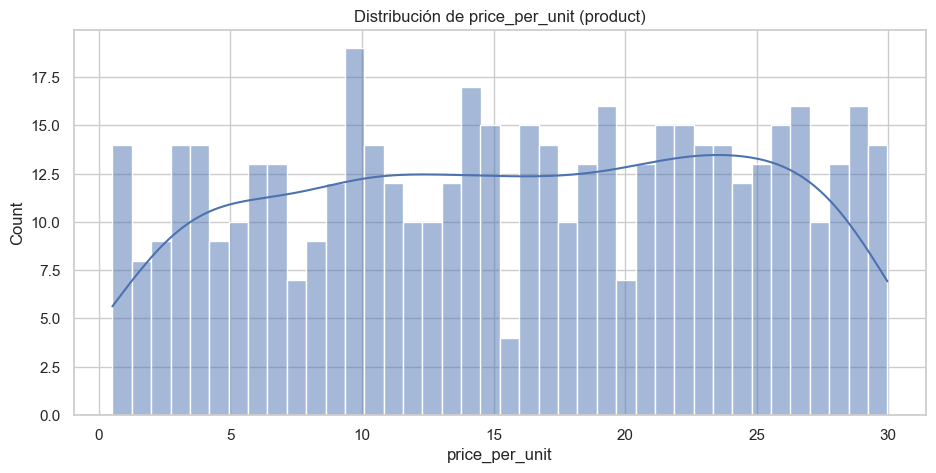

In [25]:

# %% Distribución de price_per_unit (product)
if 'price_per_unit' in product.columns:
    ax = sns.histplot(product['price_per_unit'].dropna(), bins=40, kde=True)
    ax.set_title('Distribución de price_per_unit (product)')
    ax.set_xlabel('price_per_unit')
    plt.show()


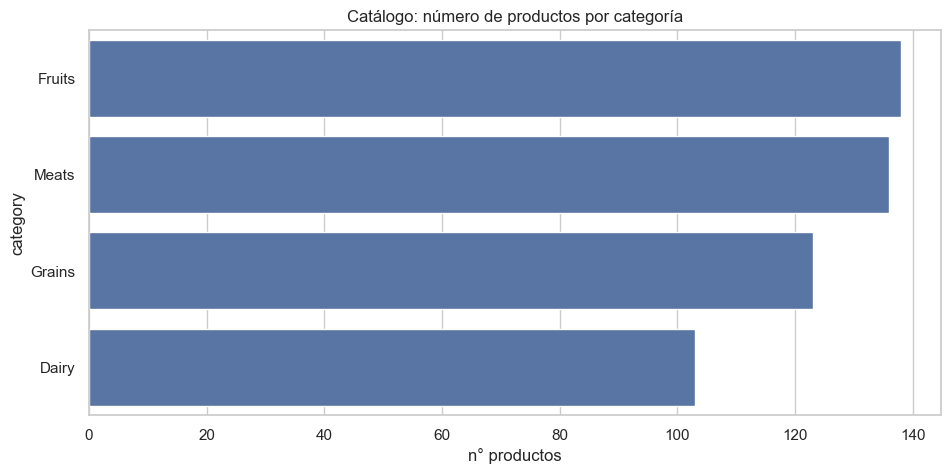

In [26]:

# %% Oferta por categoría (catálogo de productos)
if 'category' in product.columns:
    order_cat = product['category'].value_counts().index
    ax = sns.countplot(y='category', data=product, order=order_cat)
    ax.set_title('Catálogo: número de productos por categoría')
    ax.set_xlabel('n° productos')
    ax.set_ylabel('category')
    plt.show()


Top categorías por venta:
   category   total_amount
1   Fruits  221635.275945
3    Meats  219102.568844
2   Grains  194459.797381
0    Dairy  162887.315309


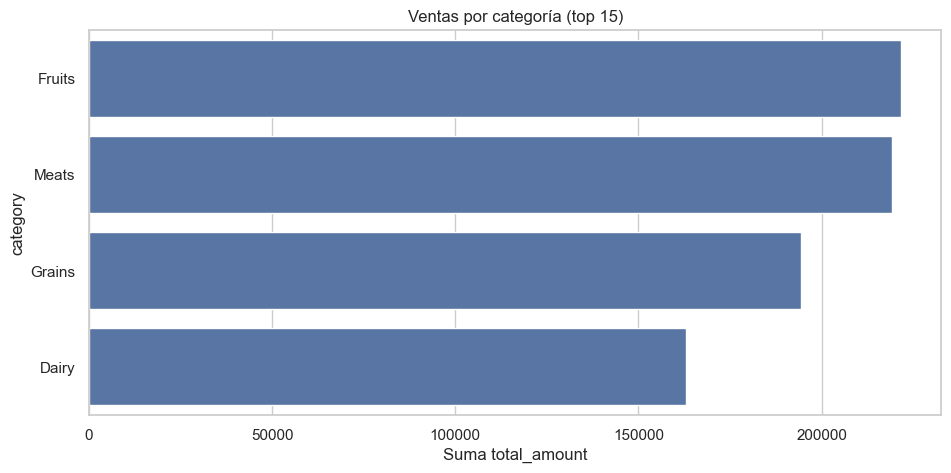

In [27]:

# %% Ventas por categoría (demanda): join purchase + product
if all(c in product.columns for c in ['product_id','category']):
    merged_cat = purchase.merge(product[['product_id','category']], on='product_id', how='left')
    sales_cat = (merged_cat.groupby('category', as_index=False)['total_amount']
                 .sum().sort_values('total_amount', ascending=False))
    print('Top categorías por venta:\n', sales_cat.head(10))
    ax = sns.barplot(x='total_amount', y='category', data=sales_cat.head(15), orient='h')
    ax.set_title('Ventas por categoría (top 15)')
    ax.set_xlabel('Suma total_amount')
    ax.set_ylabel('category')
    plt.show()


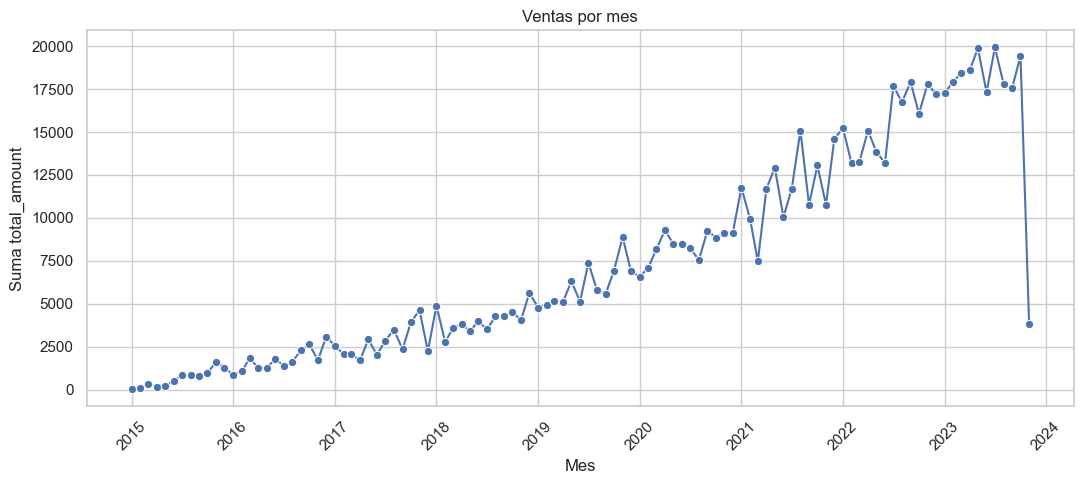

In [28]:

# %% Ventas por mes (estacionalidad)
purchase_ts = purchase.copy()
purchase_ts['purchase_date'] = pd.to_datetime(purchase_ts['purchase_date'], errors='coerce')
purchase_ts['month'] = purchase_ts['purchase_date'].dt.to_period('M').dt.to_timestamp()
sales_month = purchase_ts.groupby('month')['total_amount'].sum().reset_index()
ax = sns.lineplot(x='month', y='total_amount', data=sales_month, marker='o')
ax.set_title('Ventas por mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Suma total_amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Top 10 clientes por gasto total:
      customer_id  total_amount
459          460   2101.158435
572          573   2095.176859
402          403   2082.920560
235          236   2062.323178
191          192   2044.132281
198          199   2033.240175
601          602   2003.596025
704          705   1931.289448
829          830   1892.015874
747          748   1857.453403


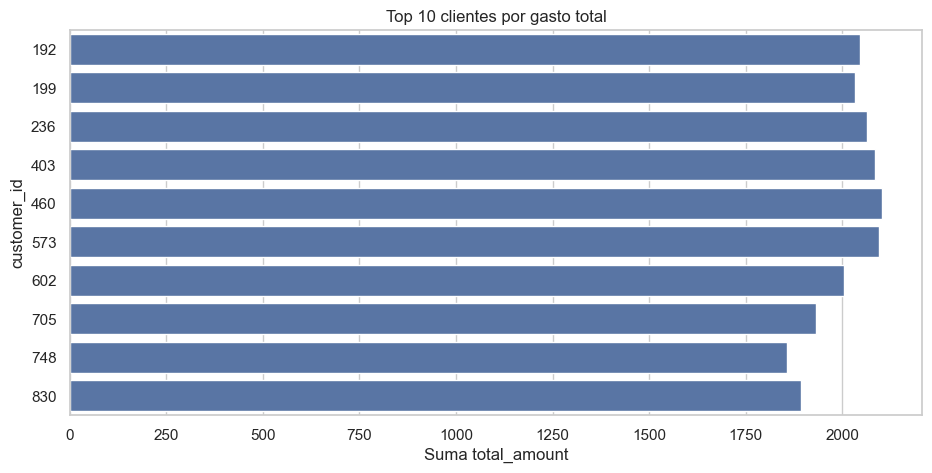

In [29]:

# %% Top 10 clientes por gasto total
top_cust = (purchase.groupby('customer_id', as_index=False)['total_amount']
            .sum().sort_values('total_amount', ascending=False).head(10))
print('Top 10 clientes por gasto total:\n', top_cust)
ax = sns.barplot(x='total_amount', y='customer_id', data=top_cust, orient='h')
ax.set_title('Top 10 clientes por gasto total')
ax.set_xlabel('Suma total_amount')
ax.set_ylabel('customer_id')
plt.show()



## Verificación de calidad
- Nulos por columna (porcentaje).
- Duplicados por llaves.
- Integridad referencial (FK): `purchase.customer_id ∈ customer`, `purchase.product_id ∈ product`.
- Reglas de negocio: `quantity > 0`, `total_amount ≥ 0`, `price_per_unit > 0`.
- Fechas fuera de rango (>= 2000 y <= hoy).
- Outliers (IQR) en `price_per_unit` y `total_amount`.
- Coherencia: `total_amount ≈ quantity * price_per_unit`.


In [30]:

# %% Nulos
def pct_nulls(df: pd.DataFrame) -> pd.Series:
    return (df.isna().mean() * 100).round(2).sort_values(ascending=False)

print('Nulos (%):')
print('- customer:\n', pct_nulls(customer))
print('\n- product:\n', pct_nulls(product))
print('\n- purchase:\n', pct_nulls(purchase))

# Duplicados
dups = {
    'customer_id_dups': customer['customer_id'].duplicated().sum() if 'customer_id' in customer.columns else None,
    'product_id_dups' : product['product_id'].duplicated().sum() if 'product_id' in product.columns else None,
    'purchase_id_dups': purchase['purchase_id'].duplicated().sum() if 'purchase_id' in purchase.columns else None,
}
print('\nDuplicados:', dups)

# Integridad referencial (FK)
fk_report = {}
if 'customer_id' in purchase.columns and 'customer_id' in customer.columns:
    fk_report['purchase_customer_fk_miss'] = int((~purchase['customer_id'].isin(customer['customer_id'])).sum())
if 'product_id' in purchase.columns and 'product_id' in product.columns:
    fk_report['purchase_product_fk_miss'] = int((~purchase['product_id'].isin(product['product_id'])).sum())
print('\nFK report:', fk_report)

# Reglas de negocio
rules = {}
if 'quantity' in purchase.columns:
    rules['qty_le_0'] = int((purchase['quantity'] <= 0).sum())
if 'total_amount' in purchase.columns:
    rules['amt_lt_0'] = int((purchase['total_amount'] < 0).sum())
if 'price_per_unit' in product.columns:
    rules['price_le_0'] = int((product['price_per_unit'] <= 0).sum())
print('\nReglas:', rules)

# Fechas fuera de rango
purchase_dates = pd.to_datetime(purchase['purchase_date'], errors='coerce')
min_allowed = pd.Timestamp('2000-01-01')
max_allowed = pd.Timestamp.today().normalize()
dates_out = int(((purchase_dates < min_allowed) | (purchase_dates > max_allowed)).sum())
print('\nFechas fuera de rango:', {'count': dates_out, 'min': str(purchase_dates.min()), 'max': str(purchase_dates.max())})

# Outliers por IQR

def iqr_outliers_count(s: pd.Series) -> int:
    s = s.dropna()
    if s.empty:
        return 0
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return int(((s < lower) | (s > upper)).sum())

outliers = {}
if 'price_per_unit' in product.columns:
    outliers['product_price_per_unit_outliers'] = iqr_outliers_count(product['price_per_unit'])
if 'total_amount' in purchase.columns:
    outliers['purchase_total_amount_outliers'] = iqr_outliers_count(purchase['total_amount'])
print('\nOutliers (IQR):', outliers)

# Coherencia de amount
if all(c in purchase.columns for c in ['product_id','quantity','total_amount']) and 'price_per_unit' in product.columns:
    tmp = purchase.merge(product[['product_id','price_per_unit']], on='product_id', how='left')
    tmp['theoretical_amount'] = tmp['quantity'] * tmp['price_per_unit']
    tmp['amount_diff'] = (tmp['total_amount'] - tmp['theoretical_amount']).round(2)
    n_large_diff = int((tmp['amount_diff'].abs() > 1e-6).sum())
    diff_abs_mean = float(tmp['amount_diff'].abs().mean())
    diff_abs_p95  = float(tmp['amount_diff'].abs().quantile(0.95))
    print('\nCoherencia total_amount vs teórico:', {
        'n_con_diferencia': n_large_diff,
        'diff_abs_mean': diff_abs_mean,
        'diff_abs_p95': diff_abs_p95
    })


Nulos (%):
- customer:
 customer_id      0.0
first_name       0.0
last_name        0.0
gender           0.0
date_of_birth    0.0
email            0.0
phone_number     0.0
signup_date      0.0
address          0.0
city             0.0
state            0.0
zip_code         0.0
dtype: float64

- product:
 product_id             0.0
product_name           0.0
category               0.0
price_per_unit         0.0
brand                  0.0
product_description    0.0
dtype: float64

- purchase:
 purchase_id      0.0
customer_id      0.0
product_id       0.0
purchase_date    0.0
quantity         0.0
total_amount     0.0
dtype: float64

Duplicados: {'customer_id_dups': np.int64(0), 'product_id_dups': np.int64(0), 'purchase_id_dups': np.int64(0)}

FK report: {'purchase_customer_fk_miss': 0, 'purchase_product_fk_miss': 0}

Reglas: {'qty_le_0': 0, 'amt_lt_0': 0, 'price_le_0': 0}

Fechas fuera de rango: {'count': 0, 'min': '2015-01-23 05:08:53', 'max': '2023-11-04 23:14:25'}

Outliers (IQR): {'pro


## Resumen de hallazgos (para documentar)
Indicadores consolidados que guiarán la Fase 3.


In [31]:

# %% Consolidación de KPIs y hallazgos
summary = {}
summary['shape_customer'] = tuple(customer.shape)
summary['shape_product']  = tuple(product.shape)
summary['shape_purchase'] = tuple(purchase.shape)

# nulos top-5 por dataset
summary['nulls_customer_pct'] = (customer.isna().mean().sort_values(ascending=False).head(5) * 100).round(2).to_dict()
summary['nulls_product_pct']  = (product.isna().mean().sort_values(ascending=False).head(5)  * 100).round(2).to_dict()
summary['nulls_purchase_pct'] = (purchase.isna().mean().sort_values(ascending=False).head(5) * 100).round(2).to_dict()

# top customer y AOV
AOV = float(purchase['total_amount'].mean()) if 'total_amount' in purchase.columns else None
try:
    top_customer_id = int(purchase.groupby('customer_id')['total_amount'].sum().idxmax())
except Exception:
    top_customer_id = None
summary['kpi'] = {'AOV': AOV, 'top_customer_id': top_customer_id}

print('=== RESUMEN FASE 2 ===')
for k, v in summary.items():
    print(k, '=>', v)


=== RESUMEN FASE 2 ===
shape_customer => (1000, 12)
shape_product => (500, 6)
shape_purchase => (10308, 6)
nulls_customer_pct => {'customer_id': 0.0, 'first_name': 0.0, 'last_name': 0.0, 'gender': 0.0, 'date_of_birth': 0.0}
nulls_product_pct => {'product_id': 0.0, 'product_name': 0.0, 'category': 0.0, 'price_per_unit': 0.0, 'brand': 0.0}
nulls_purchase_pct => {'purchase_id': 0.0, 'customer_id': 0.0, 'product_id': 0.0, 'purchase_date': 0.0, 'quantity': 0.0}
kpi => {'AOV': 77.4238414318827, 'top_customer_id': 460}
